<img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png">

© Copyright Quantopian Inc.<br>
© Modifications Copyright QuantRocket LLC<br>
Licensed under the [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/legalcode).

<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

# The Correlation Coefficient
By Evgenia "Jenny" Nitishinskaya and Delaney Granizo-Mackenzie with example algorithms by David Edwards

The correlation coefficient measures the extent to which the relationship between two variables is linear. Its value is always between -1 and 1. A positive coefficient indicates that the variables are directly related, i.e. when one increases the other one also increases. A negative coefficient indicates that the variables are inversely related, so that when one increases the other decreases. The closer to 0 the correlation coefficient is, the weaker the relationship between the variables.

The correlation coefficient of two series $X$ and $Y$ is defined as
$$r = \frac{Cov(X,Y)}{std(X)std(Y)}$$
where $Cov$ is the covariance and $std$ is the standard deviation.

Two random sets of data will have a correlation coefficient close to 0:

## Correlation vs. Covariance

Correlation is simply a normalized form of covariance. They are otherwise the same and are often used semi-interchangeably in everyday conversation. It is obviously important to be precise with language when discussing the two, but conceptually they are almost identical.

### Covariance isn't that meaningful by itself

Let's say we have two variables $X$ and $Y$ and we take the covariance of the two.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
X = np.random.rand(50)
Y = 2 * X + np.random.normal(0, 0.1, 50)

np.cov(X, Y)[0, 1]

0.22535820050858063

So now what? What does this mean? Correlation uses information about the variance of X and Y to normalize this metric. Once we've normalized the metric to the -1 to 1 scale, we can make meaningful statements and compare correlations.

To see how this is done consider the formula.

$$\frac{Cov(X, Y)}{std(X)std(Y)}$$

$$= \frac{Cov(X, Y)}{\sqrt{var(X)}\sqrt{var(Y)}}$$

$$= \frac{Cov(X, Y)}{\sqrt{Cov(X, X)}\sqrt{Cov(Y, Y)}}$$

To demonstrate this let's compare the correlation and covariance of two series.

In [3]:
X = np.random.rand(50)
Y = 2 * X + 4

print('Covariance of X and Y: \n' + str(np.cov(X, Y)))
print('Correlation of X and Y: \n' + str(np.corrcoef(X, Y)))

Covariance of X and Y: 
[[0.0755584  0.15111681]
 [0.15111681 0.30223361]]
Correlation of X and Y: 
[[1. 1.]
 [1. 1.]]


## Why do both `np.cov` and `np.corrcoef` return matrices?

The covariance matrix is an important concept in statistics. Often people will refer to the covariance of two variables $X$ and $Y$, but in reality that is just one entry in the covariance matrix of $X$ and $Y$. For each input variable we have one row and one column. The diagonal is just the variance of that variable, or $Cov(X, X)$, entries off the diagonal are covariances between different variables. The matrix is symmetric across the diagonal. Let's check that this is true.

In [4]:
cov_matrix = np.cov(X, Y)

# We need to manually set the degrees of freedom on X to 1, as numpy defaults to 0 for variance
# This is usually fine, but will result in a slight mismatch as np.cov defaults to 1
error = cov_matrix[0, 0] - X.var(ddof=1)

print('error: ' + str(error))

error: -1.3877787807814457e-17


Correlation: -0.03375245994428407
Built-in Correlation: -0.03307741074539838


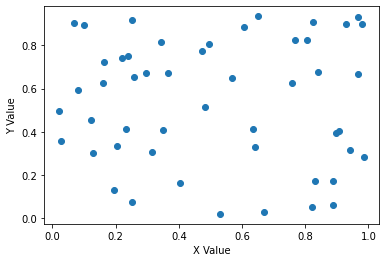

In [5]:
X = np.random.rand(50)
Y = np.random.rand(50)

plt.scatter(X,Y)
plt.xlabel('X Value')
plt.ylabel('Y Value')

# taking the relevant value from the matrix returned by np.cov
print('Correlation: ' + str(np.cov(X,Y)[0,1]/(np.std(X)*np.std(Y))))
# Let's also use the builtin correlation function
print('Built-in Correlation: ' + str(np.corrcoef(X, Y)[0, 1]))

Now let's see what two correlated sets of data look like.

Correlation: 0.9589859278091447


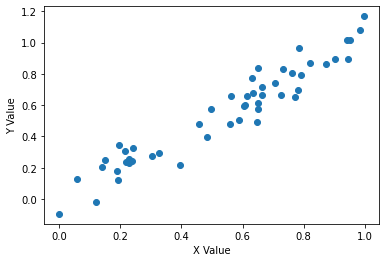

In [6]:
X = np.random.rand(50)
Y = X + np.random.normal(0, 0.1, 50)

plt.scatter(X,Y)
plt.xlabel('X Value')
plt.ylabel('Y Value')

print('Correlation: ' + str(np.corrcoef(X, Y)[0, 1]))

Let's dial down the relationship by introducing more noise.

Correlation: 0.781337299904547


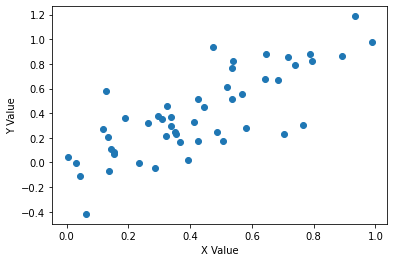

In [7]:
X = np.random.rand(50)
Y = X + np.random.normal(0, .2, 50)

plt.scatter(X,Y)
plt.xlabel('X Value')
plt.ylabel('Y Value')

print('Correlation: ' + str(np.corrcoef(X, Y)[0, 1]))

Finally, let's see what an inverse relationship looks like.

Correlation: -0.9539133074323266


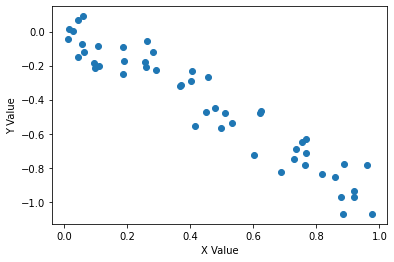

In [8]:
X = np.random.rand(50)
Y = -X + np.random.normal(0, .1, 50)

plt.scatter(X,Y)
plt.xlabel('X Value')
plt.ylabel('Y Value')

print('Correlation: ' + str(np.corrcoef(X, Y)[0, 1]))

We see a little bit of rounding error, but they are clearly the same value.

## How is this useful in finance?

### Determining related assets

Once we've established that two series are probably related, we can use that in an effort to predict future values of the series. For example, let's look at the price of Apple and Microsoft.

In [14]:
import sys
import os
root_dir = os.getcwd().replace('/quant-lectures-minutes','')
sys.path.insert(1, root_dir)

In [15]:
from utils import *

In [16]:
from zipline.utils.run_algo import load_extensions
from zipline.data import bundles
from zipline.data.data_portal import DataPortal
from zipline.utils.calendar_utils import get_calendar
import os
load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)

In [17]:
start = '2022-10-20'
end = '2022-10-29'

bundle = 'binance'
calendar_name = '24/7'
calendar = get_calendar(calendar_name)
bundle_data = bundles.load(bundle)
sids = bundle_data.asset_finder.sids
assets = bundle_data.asset_finder.retrieve_all(sids)
coin_list = [coin.symbol for coin in assets]

db = minuteBars(coins=coin_list, bundle=bundle, calendar=calendar)

In [18]:
# start = '2022-01-01'
# end = '2022-08-01'
value_list = ['close']
data = db.ohlcvData(start=start, end=end, value_list=value_list)
price = db.avgPriceData(start=start, end=end)
data.head()

close                                 \
                          1000SHIBUSDT 1000XECUSDT 1INCHUSDT AAVEUSDT   
2022-10-20 00:00:00+00:00         0.01       0.036     0.561    83.18   
2022-10-20 00:01:00+00:00         0.01       0.037     0.560    82.98   
2022-10-20 00:02:00+00:00         0.01       0.037     0.564    83.26   
2022-10-20 00:03:00+00:00         0.01       0.036     0.559    83.27   
2022-10-20 00:04:00+00:00         0.01       0.037     0.563    83.28   

                                                                         \
                          ALGOUSDT ALICEUSDT ALPHAUSDT ANKRUSDT ANTUSDT   
2022-10-20 00:00:00+00:00    0.308     1.465     0.501    0.027   1.617   
2022-10-20 00:01:00+00:00    0.308     1.525     0.501    0.029   1.613   
2022-10-20 00:02:00+00:00    0.307     1.462     0.501    0.029   1.614   
2022-10-20 00:03:00+00:00    0.307     1.526     0.501    0.029   1.617   
2022-10-20 00:04:00+00:00    0.305     1.528     0.501    0.029   1.616   

                                   ...                                    \
                          APEUSDT  ... UNIUSDT VETUSDT WAVESUSDT WOOUSDT   
2022-10-20 00:00:00+00:00   4.249  ...   6.670   0.022     3.372   0.168   
2022-10-20 00:01:00+00:00   4.237  ...   6.538   0.022     3.372   0.168   
2022-10-20 00:02:00+00:00   4.224  ...   6.538   0.022     3.372   0.168   
2022-10-20 00:03:00+00:00   4.224  ...   6.512   0.022     3.372   0.168   
2022-10-20 00:04:00+00:00   4.219  ...   6.528   0.022     3.372   0.168   

                                                                           
                          XEMUSDT XLMUSDT XRPUSDT XTZUSDT YFIUSDT ZRXUSDT  
2022-10-20 00:00:00+00:00   0.102   0.111   0.458   1.388  7489.4   0.239  
2022-10-20 00:01:00+00:00   0.102   0.111   0.452   1.388  7482.4   0.239  
2022-10-20 00:02:00+00:00   0.102   0.111   0.453   1.360  7489.4   0.237  
2022-10-20 00:03:00+00:00   0.102   0.111   0.454   1.361  7491.6   0.237  
2022-10-20 00:04:00+00:00   0.102   0.111   0.452   1.361  7492.8   0.237  

[5 rows x 116 columns]

In [19]:
len(data)

12961

### Constructing a portfolio of uncorrelated assets

Another reason that correlation is useful in finance is that uncorrelated assets produce the best portfolios. The intuition for this is that if the assets are uncorrelated, a drawdown in one will not correspond with a drawdown in another. This leads to a very stable return stream when many uncorrelated assets are combined.

## Limitations

### Significance

It's hard to rigorously determine whether or not a correlation is significant, especially when, as here, the variables are not normally distributed. Their correlation coefficient is close to 1, so it's pretty safe to say that the two stock prices are correlated over the time period we use, but is this indicative of future correlation? 

One fundamental problem is that it is easy to datamine correlations by picking the right time period. To avoid this, one should compute the correlation of two quantities over many historical time periods and examine the distibution of the correlation coefficient.

As an example, remember that the correlation of AAPL and MSFT from 2013-01-01 to 2015-01-01 was 0.92. Let's take the rolling 60 day correlation between the two to see how that varies.

Text(0, 0.5, '60-minutes Rolling Correlation')

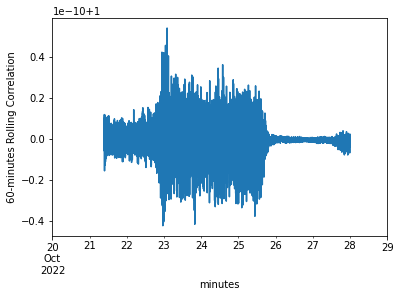

In [26]:
rolling_correlation = data.close['BTCUSDT'].rolling(2000).corr(data.close['BTCUSDT'])
ax = rolling_correlation.plot()
ax.set_xlabel('minutes')
ax.set_ylabel('60-minutes Rolling Correlation')

### Non-Linear Relationships

The correlation coefficient can be useful for examining the strength of the relationship between two variables. However, it's important to remember that two variables may be associated in different, predictable ways which this analysis would not pick up. For instance, one variable might precisely follow the behavior of a second, but with a delay. There are techniques for dealing with this lagged correlation. Alternatively, a variable may be related to the rate of change of another. Neither of these relationships are linear, but can be very useful if detected.

Additionally, the correlation coefficient can be very sensitive to outliers. This means that including or excluding even a couple of data points can alter your result, and it is not always clear whether these points contain information or are simply noise.

As an example, let's make the noise distribution poisson rather than normal and see what happens.

0.31967444924249483

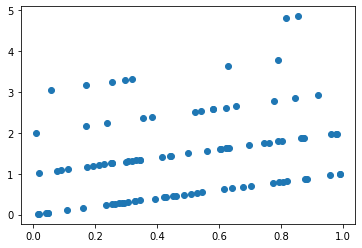

In [27]:
X = np.random.rand(100)
Y = X + np.random.poisson(size=100)

plt.scatter(X, Y)

np.corrcoef(X, Y)[0, 1]

In conclusion, correlation is a powerful technique, but as always in statistics, one should be careful not to interpret results where there are none.

---

**Next Lecture:** [Instability of Estimates](Lecture10-Instability-of-Estimates.ipynb) 

[Back to Introduction](Introduction.ipynb) 

---

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian") or QuantRocket LLC ("QuantRocket"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, neither Quantopian nor QuantRocket has taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information believed to be reliable at the time of publication. Neither Quantopian nor QuantRocket makes any guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*